In [1]:
from __future__ import print_function, division
import os, sys
import time
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
import dsp_fpga_fix_lib as fx

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, stem, grid, xlabel, ylabel, \
    subplot, title, clf, xlim, ylim
#%matplotlib notebook
%matplotlib inline
import numpy as np
from numpy import sin, cos, tan, angle, pi, array, arange, log10, zeros, \
  linspace, ones, sqrt

plt.rcParams["figure.figsize"] = [9, 6]

Für Fixpoint-Effekte muss das Filter im Zeitbereich simuliert werden mit Quantisierung etc.

In [17]:
# IIR1: Kleine Grenzzyklen für alpha = +/-0.9 mit q_accu = (0,4,'round','wrap') 
# IIR2: Großer Grenzzyklus für alpha = +0.9, x[0] = 1 und
#               q_accu = (0,4,'round','wrap') 

# Versuchen Sie auch einmal 'floor' und 'sat' für Quantisierung bzw. Überlauf

def IIR1(q_inst, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-1] + a y[i-1] >
    """
    y = zeros(len(x))
    for i in range(0,len(x)-1):
        y[i+1] = q_inst.fix(x[i] + a * y[i])
    return y
    
def IIR2(q_inst, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-2] + y[i-1] - a y[i-2] >
    """
    y = zeros(len(x))
    for i in range(len(x)-2):
        y[i+2] = q_inst.fix(x[i] + y[i+1] - y[i]*a)
    return y

Time =  0.020940065383911133
Number of overflows =  1


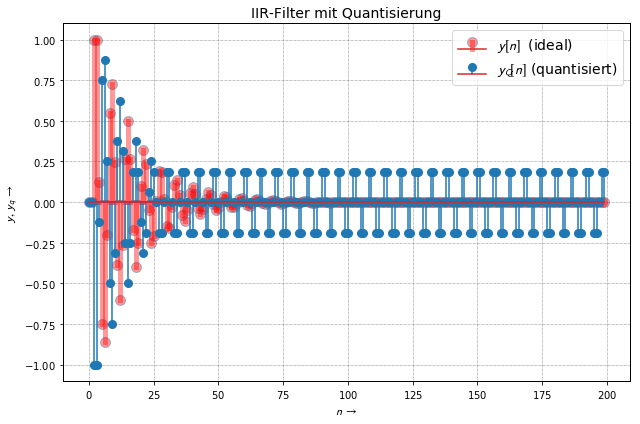

In [22]:
alpha = 0.93 # Koeffizient
N_sim = 200 # Anzahl Simulationsschritte

x = zeros(N_sim); x[0] = 1.0 # x ist dirac-Stoß mit Gew. 1.0

 # Koeffizientenquantisierung:
q_coeff = {'QI':0,'QF':3,'quant':'round','ovfl':'wrap'}
 # Quantisierung nach Summation im Filter:
#q_accu = {'QI':0,'QF':4,'quant':'fix','ovfl':'sat'} # keine Grenzzyklen
q_accu = {'Q':0.4,'quant':'round','ovfl':'wrap'}  # große Grenzzyklen bei QI = 0
# kleine Grenzzyklen mit round / floor, abhängig von alpha:
# q_accu = {'QI':0,'QF':4,'quant':'floor','ovfl':'wrap'} 

# Keine Quantisierung ->  Werte für I, F beliebig
q_ideal = {'QI':0,'QF':0,'quant':'none','ovfl':'none'}

fx_coeff = fx.Fixed(q_coeff) # Fixpoint Object mit Parametern "q_coeff"
alpha_q  = fx_coeff.fix(alpha) # berechne  quantisierten Koeffizienten

fx_IIR_id = fx.Fixed(q_ideal) # Fixpoint-Objekt ohne Quantisierung und Overflow 
fx_IIR = fx.Fixed(q_accu) # Fixpoint-Objekt mit Parametern "q_accu"

n = arange(N_sim)
t1 = time.time()

y = IIR2(fx_IIR_id, x, alpha_q) # ohne Quantisierung
yq = IIR2(fx_IIR, x, alpha_q)
#
#yq = IIR1(fx_IIR, x, alpha_q)
t2 = time.time()
print('Time = ', t2 - t1)
print('Number of overflows = ', fx_IIR.N_over)

plt.close('all')
fig1 = figure(1)
ax1 = fig1.add_subplot(1,1,1);
ax1.set_title('IIR-Filter mit Quantisierung')

grid(True)
mly, sly, bly = ax1.stem(n,y, label = r'$y[n]\;$ (ideal)')
plt.setp(mly, 'markerfacecolor', 'r', 'markersize', 10 ,'alpha', 0.4) # markerline
plt.setp(sly, 'color','r', 'linewidth', 5, 'alpha', 0.4) # stemline
ax1.stem(n, yq, label = r'$y_Q\![n]$ (quantisiert)')
ax1.legend(fontsize = 14); 
ax1.set_xlabel(r'$n \; \rightarrow$')
ax1.set_ylabel(r'$y,\, y_q \; \rightarrow$')
#
plt.tight_layout()
plt.show()